Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
# Let's start by looking at the overall df:
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
# Looking to see how many NaN values are present:
#df.isnull().sum()

In [9]:
# Changing NaN's as zeros, then looking at df:
#df = df.fillna(0)
#df.head()

In [10]:
# Train/Val/Test split:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
cutoff1 = pd.to_datetime('2016-12-31')
cutoff2 = pd.to_datetime('2018-01-01')
train = df[df.Date <= cutoff1]
val = df[(df.Date > cutoff1) & (df.Date < cutoff2)]
test = df[df.Date >= cutoff2]

In [11]:
# Looking at the shape of the train/val/test df's:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

In [12]:
# Baselines for classification; Determining majority class:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [13]:
majority_class = y_train.mode(dropna=True)[0]
y_pred_train = [majority_class]*len(y_train)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [15]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [16]:
# Looking at train to select 5 features:
train.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [31]:
# Picking features:
features = ['Sour cream', 'Cilantro', 'Avocado', 'Meat', 'Tortilla']
target = 'Great'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, X_val.shape

((298, 5), (85, 5))

In [32]:
# Importing required:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [33]:
# OneHotEncoding:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape, X_val_enc.shape

((298, 10), (85, 10))

In [34]:
# Looking at validation encoded:
X_val_enc.head()

,Sour cream_nan,Sour cream_x,Sour cream_X,Cilantro_nan,Cilantro_x,Cilantro_X,Avocado_nan,Avocado_x,Meat,Tortilla
301,1,0,0,1,0,0,1,0,4.0,4.0
302,1,0,0,1,0,0,1,0,NaN,4.0
303,1,0,0,1,0,0,1,0,4.1,3.0
304,1,0,0,1,0,0,1,0,4.0,3.5
305,1,0,0,1,0,0,1,0,3.0,2.5


In [35]:
# Imputing:
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_train_imp.shape, X_val_imp.shape

((298, 10), (85, 10))

In [36]:
# Getting validation score in next several cells:
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns = X_val_enc.columns)

In [37]:
X_val_imp

,Sour cream_nan,Sour cream_x,Sour cream_X,Cilantro_nan,Cilantro_x,Cilantro_X,Avocado_nan,Avocado_x,Meat,Tortilla
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.000000,4.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.551215,4.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.100000,3.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.000000,3.5
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.000000,2.5
...,...,...,...,...,...,...,...,...,...,...
80,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.800000,3.0
81,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.000000,3.0
82,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.000000,2.0
83,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.000000,4.0


In [38]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [39]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val_enc.columns)

In [40]:
X_train_sc.head()

,Sour cream_nan,Sour cream_x,Sour cream_X,Cilantro_nan,Cilantro_x,Cilantro_X,Avocado_nan,Avocado_x,Meat,Tortilla
0,0.631713,-0.517769,-0.28233,0.230225,-0.176471,-0.143346,0.213574,-0.213574,-0.645992,-0.593162
1,0.631713,-0.517769,-0.28233,0.230225,-0.176471,-0.143346,0.213574,-0.213574,-1.231964,-1.849023
2,0.631713,-0.517769,-0.28233,0.230225,-0.176471,-0.143346,0.213574,-0.213574,-1.231964,-0.593162
3,0.631713,-0.517769,-0.28233,0.230225,-0.176471,-0.143346,0.213574,-0.213574,-0.060021,-0.593162
4,0.631713,-0.517769,-0.28233,0.230225,-0.176471,-0.143346,0.213574,-0.213574,0.525950,0.662698


In [41]:
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [42]:
print(f'Validation score: {model.score(X_val_sc, y_val)}')

Validation score: 0.7764705882352941


In [43]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Sour cream_nan   -0.009389
Sour cream_x      0.137827
Sour cream_X     -0.199003
Cilantro_nan      0.022127
Cilantro_x       -0.076294
Cilantro_X        0.058516
Avocado_nan       0.280956
Avocado_x        -0.280956
Meat              1.847788
Tortilla          0.923960
dtype: float64

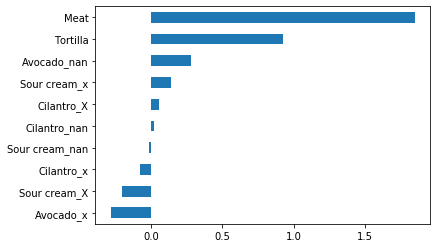

In [45]:
coefs.sort_values().plot.barh();

In [46]:
# Getting Test Accuracy in next several cells:
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imp = imputer.transform(X_test_enc)
X_test_scaled = scaler.transform(X_test_imp)
X_test_scaled

array([[ 6.31712777e-01, -5.17769356e-01, -2.82329851e-01,
         2.30224963e-01, -1.76470588e-01, -1.43345545e-01,
         2.13574425e-01, -2.13574425e-01,  1.69789203e+00,
         1.29062863e+00],
       [ 6.31712777e-01, -5.17769356e-01, -2.82329851e-01,
         2.30224963e-01, -1.76470588e-01, -1.43345545e-01,
         2.13574425e-01, -2.13574425e-01,  5.25949777e-01,
         6.62698293e-01],
       [-1.58299790e+00,  1.93136188e+00, -2.82329851e-01,
         2.30224963e-01, -1.76470588e-01, -1.43345545e-01,
         2.13574425e-01, -2.13574425e-01, -1.81793472e+00,
        -5.93162383e-01],
       [ 6.31712777e-01, -5.17769356e-01, -2.82329851e-01,
         2.30224963e-01, -1.76470588e-01, -1.43345545e-01,
         2.13574425e-01, -2.13574425e-01,  1.69789203e+00,
         1.91855897e+00],
       [ 6.31712777e-01, -5.17769356e-01, -2.82329851e-01,
         2.30224963e-01, -1.76470588e-01, -1.43345545e-01,
         2.13574425e-01, -2.13574425e-01, -6.45992473e-01,
         6.

In [47]:
y_pred = model.predict(X_test_scaled)
y_pred

array([ True,  True, False,  True, False,  True,  True,  True, False,
        True,  True, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True,  True, False,
        True, False,  True, False,  True,  True,  True, False,  True,
        True,  True])

In [49]:
# Test Accuracy:
y_test = test[target]
print('Test Accuracy', model.score(X_test_scaled, y_test))

Test Accuracy 0.6842105263157895
